In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import wordcloud
from wordcloud import WordCloud

import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, LSTM, Dense

In [14]:
# Leer el archivo csv

data = pd.read_csv('uci-news-aggregator.csv')

In [15]:
# Ver las primeras filas del dataset
print(data.head())

# Resumen estadístico de las columnas numéricas
print(data.describe())

# Información sobre el dataset
print(data.info())

   ID                                              TITLE  \
0   1  Fed official says weak data caused by weather,...   
1   2  Fed's Charles Plosser sees high bar for change...   
2   3  US open: Stocks fall after Fed official hints ...   
3   4  Fed risks falling 'behind the curve', Charles ...   
4   5  Fed's Plosser: Nasty Weather Has Curbed Job Gr...   

                                                 URL          PUBLISHER  \
0  http://www.latimes.com/business/money/la-fi-mo...  Los Angeles Times   
1  http://www.livemint.com/Politics/H2EvwJSK2VE6O...           Livemint   
2  http://www.ifamagazine.com/news/us-open-stocks...       IFA Magazine   
3  http://www.ifamagazine.com/news/fed-risks-fall...       IFA Magazine   
4  http://www.moneynews.com/Economy/federal-reser...          Moneynews   

  CATEGORY                          STORY             HOSTNAME      TIMESTAMP  
0        b  ddUyU0VZz0BRneMioxUPQVP6sIxvM      www.latimes.com  1394470370698  
1        b  ddUyU0VZz0BRneMi

# Actividad 1: EDA sobre nuestro corpus

Para conocer mejor el corpus con el que estamos trabajando vamos a realizar algunas tareas de 
EDA. En nuestro caso, el EDA consistirá en construir gráficos de barras que muestren cómo se distribuyen los  artículos en el dataset de acuerdo a:

- Mes en el que fueron publicados (el mes se extrae de la columna TIMESTAMP)
- Categorías
    - Muestra también el % de artículos del dataset que pertenecen a cada categoría.
- Publishers

Utiliza la librería “wordcloud” para generar nubes de palabras por categoría

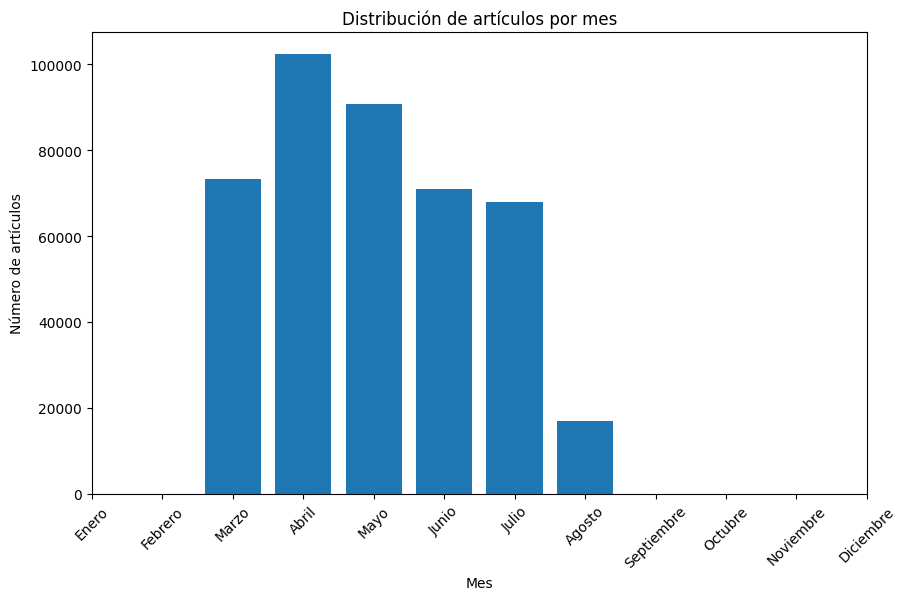

In [16]:
# Convertir TIMESTAMP a formato de fecha
data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'], unit='ms')

# Extraer el mes de la columna TIMESTAMP
data['Month'] = data['TIMESTAMP'].dt.month

# Calcular la distribución de artículos por mes
month_counts = data['Month'].value_counts().sort_index()

# Crear un gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(month_counts.index, month_counts.values)
plt.xlabel('Mes')
plt.ylabel('Número de artículos')
plt.title('Distribución de artículos por mes')
plt.xticks(range(1, 13), ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre'], rotation=45)
plt.show()

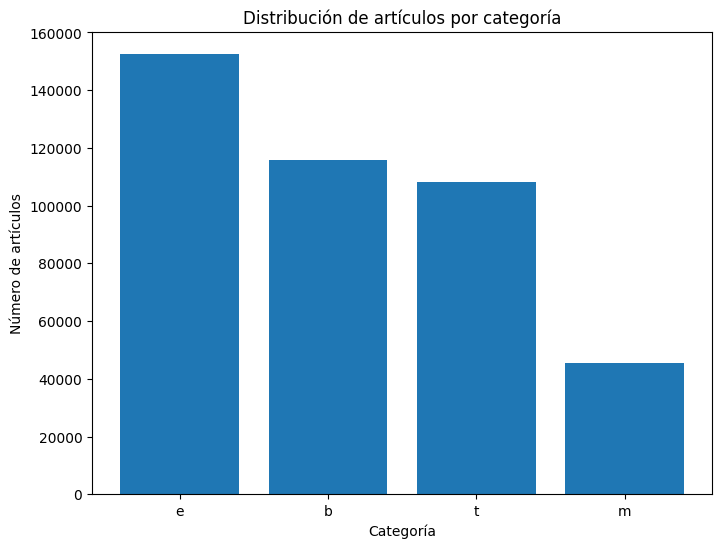

CATEGORY
e    36.094257
b    27.453074
t    25.648468
m    10.804202
Name: count, dtype: float64


In [17]:
# Gráfico de barras para mostrar la distribución de categorías
category_counts = data['CATEGORY'].value_counts()
category_percentages = category_counts / len(data) * 100

plt.figure(figsize=(8, 6))
plt.bar(category_counts.index, category_counts)
plt.xlabel('Categoría')
plt.ylabel('Número de artículos')
plt.title('Distribución de artículos por categoría')
plt.show()

# Muestra el porcentaje de artículos por categoría
print(category_percentages)

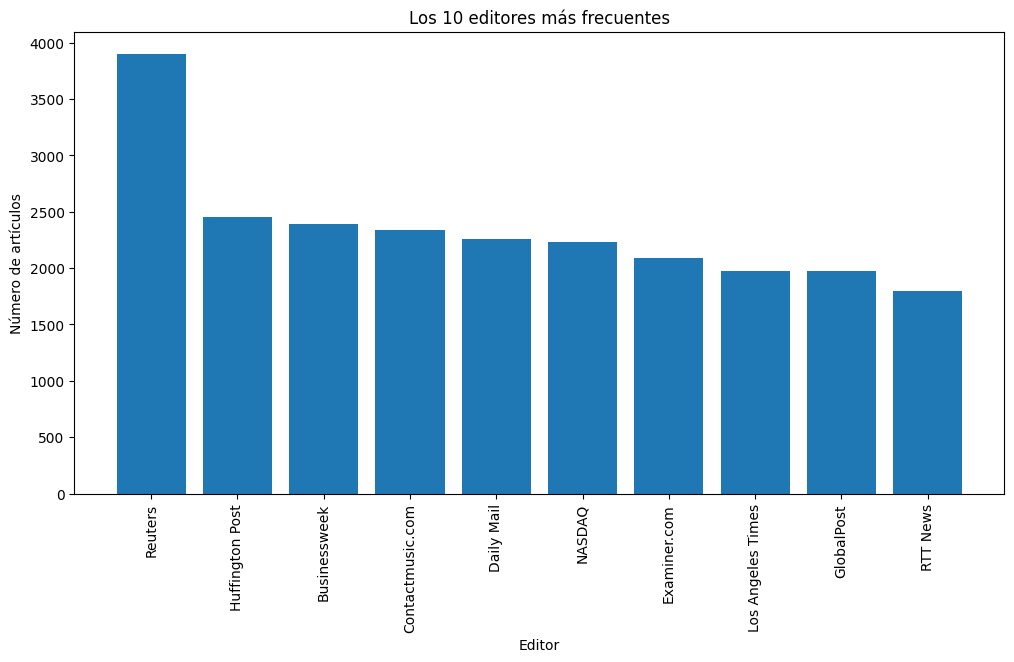

In [18]:
# Gráfico de barras para mostrar los editores (publishers) más frecuentes
publisher_counts = data['PUBLISHER'].value_counts()[:10]

plt.figure(figsize=(12, 6))
plt.bar(publisher_counts.index, publisher_counts)
plt.xlabel('Editor')
plt.ylabel('Número de artículos')
plt.title('Los 10 editores más frecuentes')
plt.xticks(rotation=90)
plt.show()

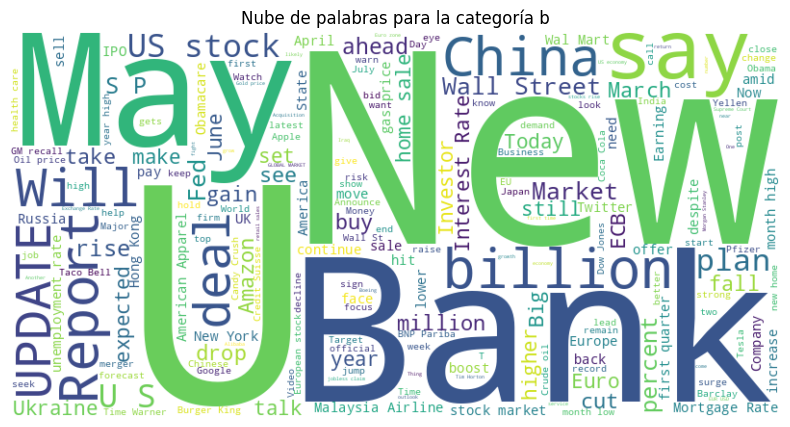

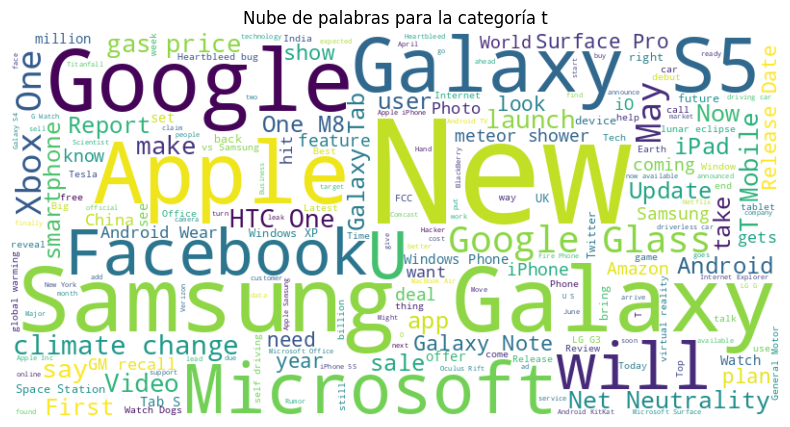

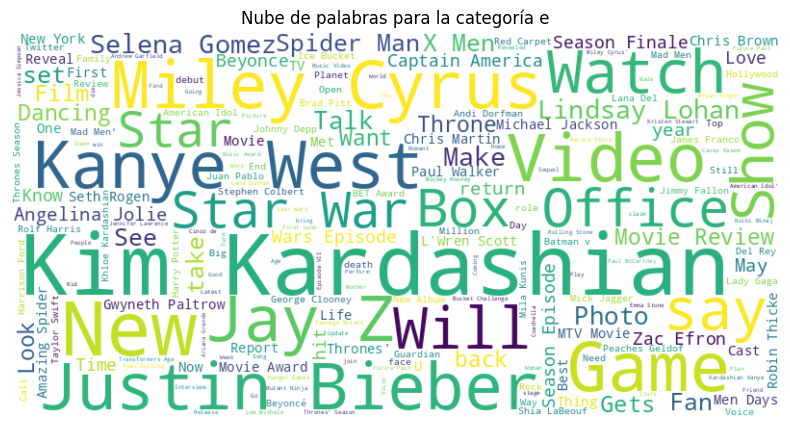

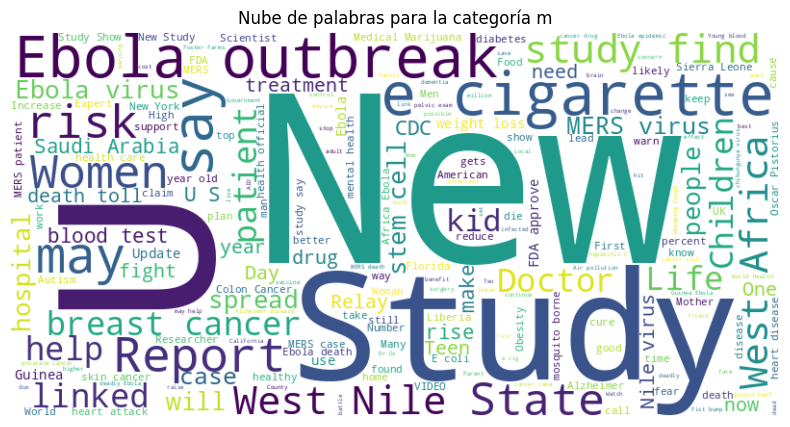

In [19]:
# Crear nubes de palabras por categoría
categories = data['CATEGORY'].unique()

for category in categories:
    # Filtrar datos por categoría
    category_data = data[data['CATEGORY'] == category]
    
    # Combinar los títulos en un solo texto
    title_text = " ".join(category_data['TITLE'])
    
    # Crear una nube de palabras
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(title_text)
    
    # Mostrar la nube de palabras
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Nube de palabras para la categoría {category}')
    plt.show()

# Actividad 2: Clasificación del texto

Vamos a comparar el desempeño de los siguientes modelos:

- Logistic Regression
    - Utilizar BoW y TD-IDF
- Naive Bayes
    - Utilizar BoW y TD-IDF
- CNN
- LSTM

Para lleva a cabo la comparación hay que seguir estos pasos:

1. Preprocesamiento y normalización del texto. Eliminar las STOPWORDS, convertir a minúsculas, 
quitar símbolos no alfabéticos, etc.

2. Construir y entrenar el modelo

    1. Generar métricas de desempeño (accuracy al final del entrenamiento)
    
    2. Realizar predicciones de prueba con nuevos títulos (ver más abajo) y generar métricas del  desepeño (acuracy con las nuevas predicciones)
    
3. Construir una tabla para mostrar el desempeño de los modelos

In [20]:
# Preprocesamiento de texto
def preprocess_text(text):
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar símbolos de puntuación y dígitos
    text = re.sub(f"[{re.escape(string.punctuation)}{re.escape(string.digits)}]", "", text)
    # Eliminar palabras vacías (stop words)
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
    return text

data['TITLE'] = data['TITLE'].apply(preprocess_text)

# Dividir los datos en conjuntos de entrenamiento y prueba
X = data['TITLE']
y = data['CATEGORY']
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Entrenar modelos Logistic Regression y Naive Bayes

# Representación Bag of Words (BoW)
count_vectorizer = CountVectorizer()
X_train_bow = count_vectorizer.fit_transform(X_train)
X_test_bow = count_vectorizer.transform(X_test)

# Aumentar el número de iteraciones en el modelo de regresión logística
lr_bow = LogisticRegression(max_iter=1000)  # Aumentar el número de iteraciones
lr_bow.fit(X_train_bow, y_train)
lr_bow_accuracy = accuracy_score(y_test, lr_bow.predict(X_test_bow))

nb_bow = MultinomialNB()
nb_bow.fit(X_train_bow, y_train)
nb_bow_accuracy = accuracy_score(y_test, nb_bow.predict(X_test_bow))

# Representación TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Aumentar el número de iteraciones en el modelo de regresión logística
lr_tfidf = LogisticRegression(max_iter=1000)  # Aumentar el número de iteraciones
lr_tfidf.fit(X_train_tfidf, y_train)
lr_tfidf_accuracy = accuracy_score(y_test, lr_tfidf.predict(X_test_tfidf))

nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_tfidf, y_train)
nb_tfidf_accuracy = accuracy_score(y_test, nb_tfidf.predict(X_test_tfidf))

# Entrenar modelo CNN
max_words = 10000
max_sequence_length = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_seq = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_seq = pad_sequences(X_test_seq, maxlen=max_sequence_length)

cnn_model = Sequential()
cnn_model.add(Embedding(max_words, 128, input_length=max_sequence_length))
cnn_model.add(Conv1D(64, 3, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(4, activation='softmax'))

cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.fit(X_train_seq, y_train, validation_data=(X_test_seq, y_test), epochs=10, batch_size=64)
_, cnn_accuracy = cnn_model.evaluate(X_test_seq, y_test)

# Entrenar modelo LSTM

lstm_model = Sequential()
lstm_model.add(Embedding(max_words, 128, input_length=max_sequence_length))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(4, activation='softmax'))

lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.fit(X_train_seq, y_train, validation_data=(X_test_seq, y_test), epochs=10, batch_size=64)
_, lstm_accuracy = lstm_model.evaluate(X_test_seq, y_test)

Epoch 1/10


2023-10-30 18:07:29.536854: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 135174000 exceeds 10% of free system memory.


5281/5281 [==============================] - 99s 19ms/step - loss: 0.2281 - accuracy: 0.9187 - val_loss: 0.1767 - val_accuracy: 0.9381
Epoch 2/10
5281/5281 [==============================] - 96s 18ms/step - loss: 0.1363 - accuracy: 0.9518 - val_loss: 0.1713 - val_accuracy: 0.9419
Epoch 3/10
5281/5281 [==============================] - 94s 18ms/step - loss: 0.0985 - accuracy: 0.9653 - val_loss: 0.1827 - val_accuracy: 0.9411
Epoch 4/10
5281/5281 [==============================] - 96s 18ms/step - loss: 0.0700 - accuracy: 0.9756 - val_loss: 0.2062 - val_accuracy: 0.9390
Epoch 5/10
5281/5281 [==============================] - 114s 22ms/step - loss: 0.0513 - accuracy: 0.9822 - val_loss: 0.2346 - val_accuracy: 0.9374
Epoch 6/10
5281/5281 [==============================] - 105s 20ms/step - loss: 0.0403 - accuracy: 0.9864 - val_loss: 0.2668 - val_accuracy: 0.9344
Epoch 7/10
5281/5281 [==============================] - 98s 19ms/step - loss: 0.0340 - accuracy: 0.9887 - val_loss: 0.2782 - val_accu

2023-10-30 18:24:06.433844: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 135174000 exceeds 10% of free system memory.


5281/5281 [==============================] - 359s 68ms/step - loss: 0.2291 - accuracy: 0.9174 - val_loss: 0.1796 - val_accuracy: 0.9360
Epoch 2/10
5281/5281 [==============================] - 360s 68ms/step - loss: 0.1536 - accuracy: 0.9444 - val_loss: 0.1686 - val_accuracy: 0.9401
Epoch 3/10
5281/5281 [==============================] - 365s 69ms/step - loss: 0.1267 - accuracy: 0.9536 - val_loss: 0.1683 - val_accuracy: 0.9412
Epoch 4/10
5281/5281 [==============================] - 363s 69ms/step - loss: 0.1058 - accuracy: 0.9611 - val_loss: 0.1753 - val_accuracy: 0.9416
Epoch 5/10
5281/5281 [==============================] - 358s 68ms/step - loss: 0.0880 - accuracy: 0.9674 - val_loss: 0.1887 - val_accuracy: 0.9410
Epoch 6/10
5281/5281 [==============================] - 365s 69ms/step - loss: 0.0723 - accuracy: 0.9727 - val_loss: 0.2066 - val_accuracy: 0.9394
Epoch 7/10
5281/5281 [==============================] - 364s 69ms/step - loss: 0.0587 - accuracy: 0.9777 - val_loss: 0.2253 - val

In [1]:
# Métricas de desempeño
accuracies = [lr_bow_accuracy, lr_tfidf_accuracy, nb_bow_accuracy, nb_tfidf_accuracy, cnn_accuracy, lstm_accuracy]
models = ['Logistic Regression (BoW)', 'Logistic Regression (TF-IDF)', 'Naive Bayes (BoW)', 'Naive Bayes (TF-IDF)', 'CNN', 'LSTM']

# Crear gráfica de barras
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'red', 'purple', 'orange', 'gray'])
plt.title('Desempeño de Modelos de Clasificación de Texto')
plt.xlabel('Modelos')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')

# Mostrar la gráfica
plt.tight_layout()
plt.show()

NameError: name 'lr_bow_accuracy' is not defined

In [ ]:
# Realizar predicciones de prueba con nuevos títulos (reemplaza 'X_new' con tus nuevos datos)
X_new_seq = tokenizer.texts_to_sequences(X_new)
X_new_seq = pad_sequences(X_new_seq, maxlen=max_sequence_length)

predictions_cnn = cnn_model.predict(X_new_seq)
predictions_lstm = lstm_model.predict(X_new_seq)

# Generar métricas de desempeño para las predicciones de prueba (reemplaza 'y_new' con las etiquetas reales)
accuracy_cnn = accuracy_score(y_new, np.argmax(predictions_cnn, axis=1))
accuracy_lstm = accuracy_score(y_new, np.argmax(predictions_lstm, axis=1))

print(f'CNN - Accuracy en predicciones de prueba: {accuracy_cnn:.4f}')
print(f'LSTM - Accuracy en predicciones de prueba: {accuracy_lstm:.4f}')

# Métricas de desempeño en predicciones de prueba
accuracies_test = [accuracy_cnn, accuracy_lstm]
models_test = ['CNN', 'LSTM']

# Crear gráfica de barras
plt.figure(figsize=(6, 4))
plt.bar(models_test, accuracies_test, color=['blue', 'green'])
plt.title('Desempeño de Modelos en Predicciones de Prueba')
plt.xlabel('Modelos')
plt.ylabel('Accuracy')

# Mostrar la gráfica
plt.tight_layout()
plt.show()